# 荧光强度与荧光寿命

## 荧光强度

导入 python 库函数，并设置计算荧光强度的积分时间，默认为 50 ms

In [1]:
%matplotlib notebook
import photon_correlation as pc

# 在单引号中输入要处理的文件名以初始化
info = pc.Info('lt.pt3')

# 设置积分时间单位为 ps，默认 50 ms
# info.set_bin_width(50E9)

<IPython.core.display.Javascript object>


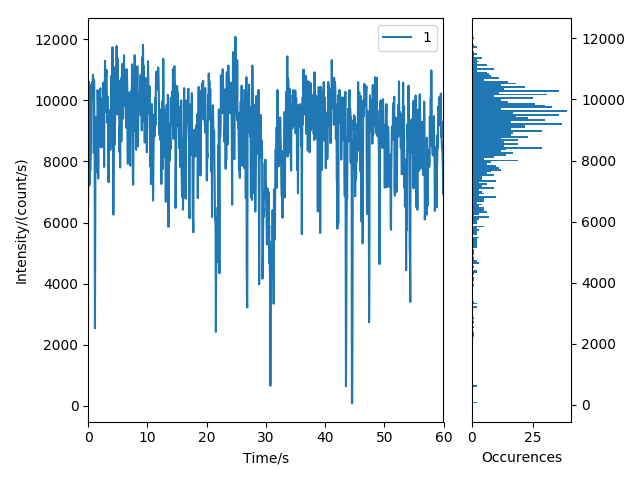

In [2]:
intensity_file = pc.calculate.intensity(info.get_filename(),
                                        bin_width=info.get_bin_width(),
                                        mode=info.get_mode(),
                                        channels=info.get_channels())

intensity = pc.Intensity(intensity_file, mode=info.get_mode())

intensity.pulses_to_seconds(info.get_repetition_rate()).make_figure()

In [3]:
# 导出强度与强度分布数据
# intensity.pulses_to_seconds(info.get_repetition_rate()).export_Intensity(info.get_filename()+'.Intensity')
# intensity.pulses_to_seconds(info.get_repetition_rate()).export_histogram(info.get_filename()+'.Histogram')

## 计算荧光寿命并拟合

首先，根据荧光强度图选择合适的强度阈值（对应亮、暗态），并进行一次计算，作图。亮、暗态的阈值强度 ，直接在交互式图表上读取坐标值即可。

<IPython.core.display.Javascript object>


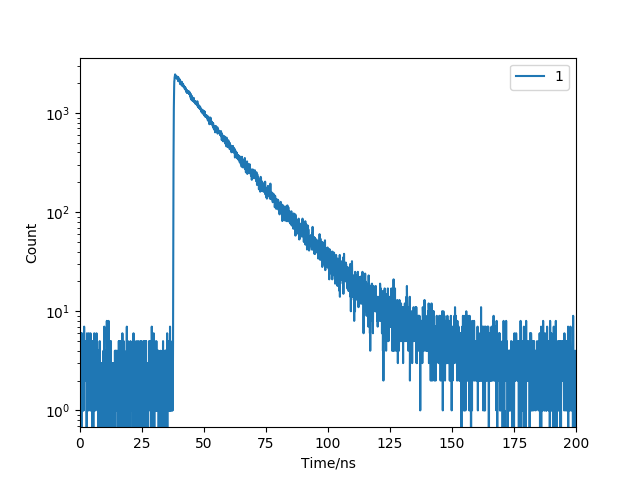

In [4]:
# 设置计算寿命的强度阈值
# info.set_threshold_min(0)
# info.set_threshold_max(1000000)

g1_file = pc.calculate.gn(info.get_filename(), order=info.get_order(),
                          photon_mode=info.get_mode(), gn_mode=info.get_mode(),
                          channels=info.get_channels(), window_width=info.get_bin_width(),
                          threshold_min=info.get_threshold_min(),
                          threshold_max=info.get_threshold_max())

lifetimes = pc.G1(g1_file)

lifetimes.make_figure()

二次计算与处理。假定测量中 picoharp 控制盒没有连接 router 进行多通道采集，那么荧光的寿命信息就存储在 1 通道。
第三条代码的作用是利用 origin() 函数找到寿命曲线最大值，并返回该值对应的时间坐标，以此给出二次计算寿命所需的通道时间补偿量。
经过这一修正可使得寿命曲线最大值出现在 0 时刻。
而随后的 2000 (ps) 补偿为通常的上升时间，这使得脉冲的上升沿完整出现在 0 时刻以后。
如果样品特殊，上升时间比较长，可作相应修正。

A1 = 2257.60,	 t1 = 13318.17 ps
B  = 6.02



<IPython.core.display.Javascript object>


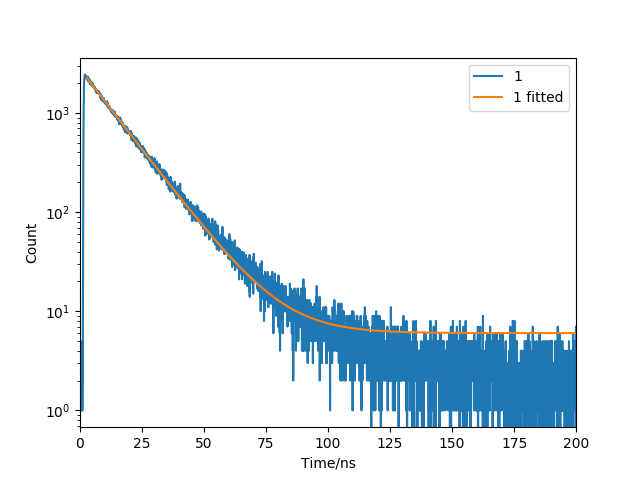

In [5]:
lifetime = lifetimes[1]
# 计算中，0 通道为激光同步信号通道，不设置位移量。
time_offsets = [0]
# 通道时间补偿操作，令寿命曲线的激发处于 0 时刻。
time_offsets.append(-lifetime.origin()*info.get_resolution() + 2000)

g1_file = pc.calculate.gn(info.get_filename(), order=info.get_order(),
                          photon_mode=info.get_mode(), gn_mode=info.get_mode(),
                          channels=info.get_channels(), window_width=info.get_bin_width(),
                          time_offsets = time_offsets, # 这里相对一次计算，引入了通道时间补偿
                          threshold_min=info.get_threshold_min(),
                          threshold_max=info.get_threshold_max())

lifetimes = pc.G1(g1_file)

# 对 1 通道寿命进行 n 指数拟合
# 返回值分别为拟合曲线与拟合结果表
# 需要更改 n 指数，改最后一个数字
lifetime_fit, fit_table = lifetimes[1].exponential_fit(n_exponentials=1)

# 11 = 10 + 1 用于产生图上相应的 'fitted' 标签
lifetimes[11] = lifetime_fit

# 打印拟合结果
print(fit_table)

lifetimes.make_figure()

In [6]:
# 导出寿命
# lifetimes.export_lifetime(info.get_filename()+'.lifetime')